# Classification Model Predicting White Wine Quality


## Introduction

Vinho Verde wine is renowned for its savoury taste and stress-relief benefits. A study suggests that the global dry white wine industry surged in 2022 and is expected to maintain an upward trend to 2030 (Market Reports World, 2023). This urging demand rendered wine quality classification daily more significant. Therefore, we aim to design a classification model for the quality of Vinho Verde. We will utilize the “Wine Quality” dataset taken from the UC Irvine Machine Learning Repository, which features 11 physicochemical attributes of wines, such as fixed acidity, citric acid, residual sugar, density, and a quality variable. All variables, except quality, are quantitative. We aim to use these quantitative variables to predict categorical variables(quality). This dataset includes variables for white Vinho Verde, with the majority represented in grams/dm^3, except free_sulfur_dioxide and total_sulfur_dioxide which in milligrams/dm^3, and pH, which are represented from 0 to 14. Additionally, the dataset contains 4898 observations with no empty values. In summary, the project will involve cleaning and preprocessing of the Vinho Verde dataset,  with implementation of appropriate algorithms and k-nearest-neighbor classification models for wine quality predictions.

**Predictive Question:** How to predict White Wine Quality using it's physicochemical attributes?

## Preliminary exploratory data analysis:

In [103]:
# Run This Cell Before Continuing
set.seed(999)
library(repr)
library(tidyverse)
library(tidymodels)
library(janitor)
library(cowplot)

In [104]:
url <- "https://raw.githubusercontent.com/TrBili/dsci-100-project/main/data/winequality-white.csv"
download.file(url, "data/winequality-white.csv")


In [105]:
wine_data_raw <- read_csv2("data/winequality-white.csv")


wine_data <- wine_data_raw |> clean_names() |>
                map_df(as.numeric) |>
                mutate(quality = as_factor(quality)) 
                

head(wine_data)

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Rows: 4898 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (6): volatile acidity, citric acid, residual sugar, chlorides, density, ...
dbl (1): quality
num (5): fixed acidity, free sulfur dioxide, total sulfur dioxide, pH, alcohol

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,p_h,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7,0.27,0.36,20.7,0.045,45,170,1.0010,3,0.45,88,6
63,0.30,0.34,1.6,0.049,14,132,0.9940,33,0.49,95,6
81,0.28,0.40,6.9,0.050,30,97,0.9951,326,0.44,101,6
72,0.23,0.32,8.5,0.058,47,186,0.9956,319,0.40,99,6
72,0.23,0.32,8.5,0.058,47,186,0.9956,319,0.40,99,6
81,0.28,0.40,6.9,0.050,30,97,0.9951,326,0.44,101,6


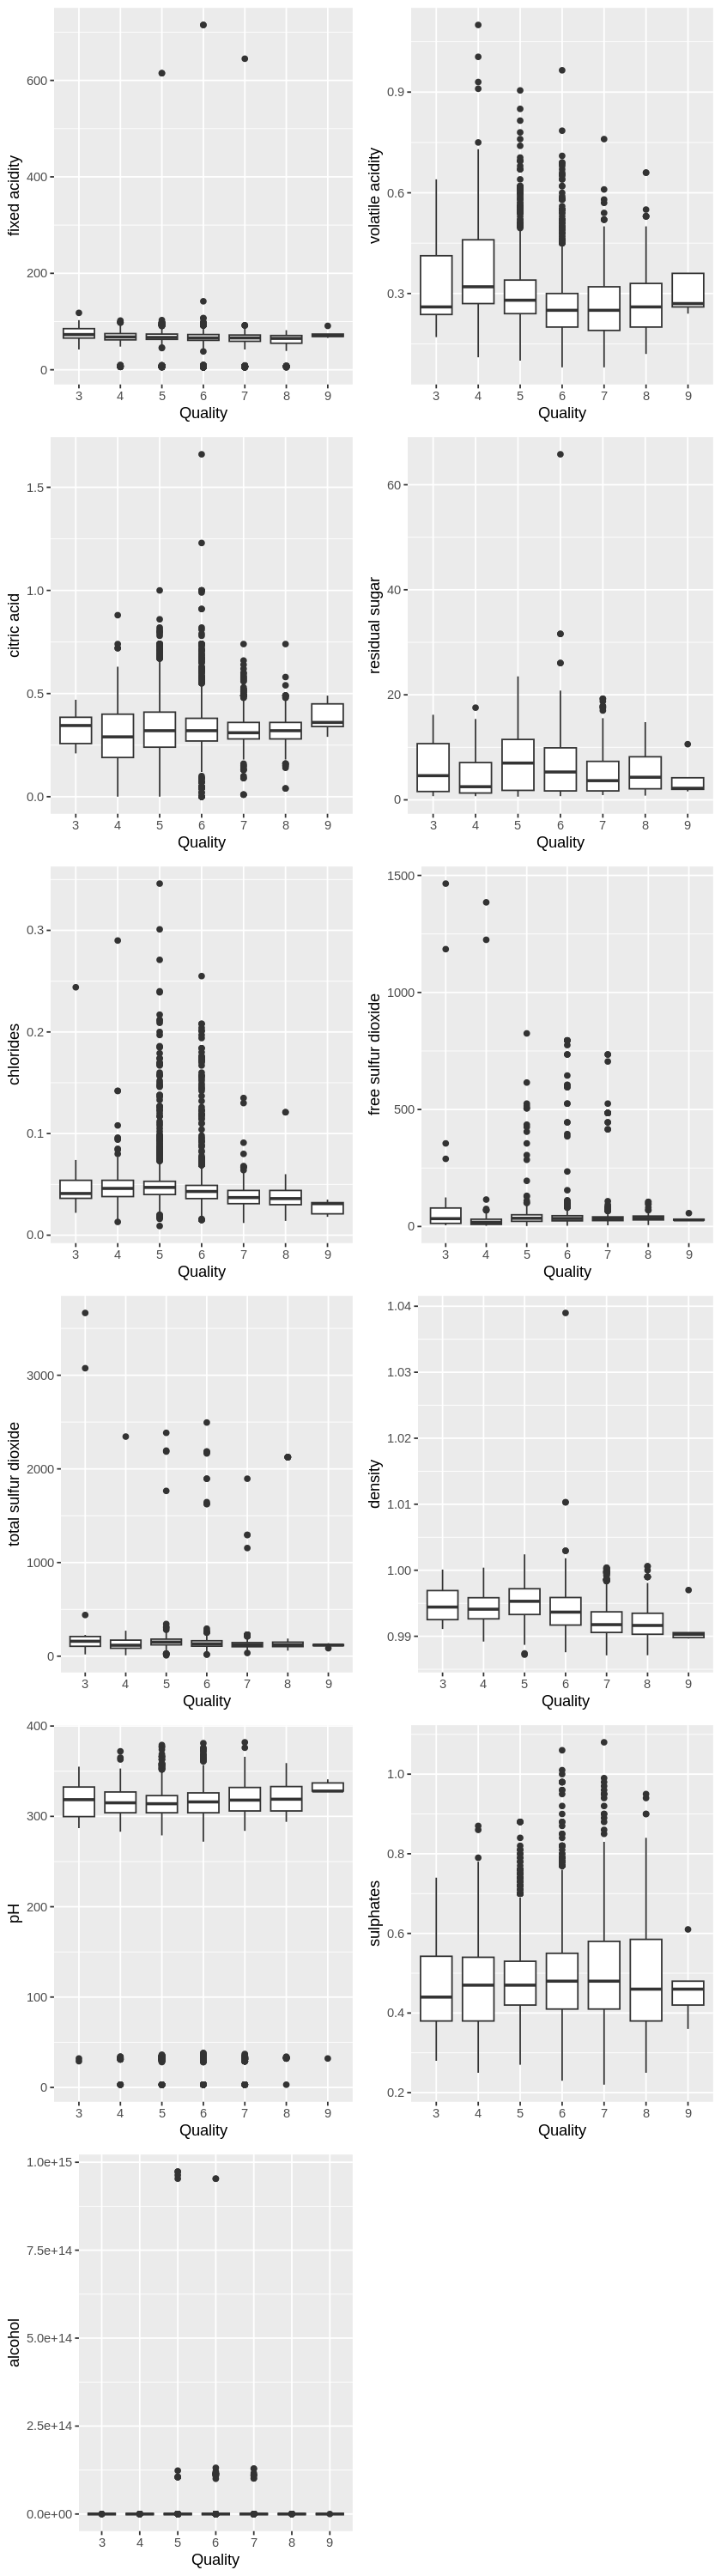

In [106]:
## Setting the Width & Height of the Plot
options(repr.plot.width=7,repr.plot.height=25)

## Extracting all the column names from our clean Dataset
all_cols <- wine_data |> select(-quality) |> colnames()

## Extracting all the column names from our raw Dataset
col_names <- wine_data_raw |> colnames()

## Creating a list to store all our plots
plots <- list()

## Loop Variable
i <- 0

## Looping through each column
for(c in all_cols) {
    i <- i + 1
    c_sym <- sym(c)
    box_plot <- ggplot(wine_data, aes(x=quality,y=!!c_sym)) +
            geom_boxplot() +
            labs(x="Quality", y=col_names[i])
    plots[[c]] <- box_plot
}

## Merging all the plots
plot_grid(plotlist = plots, ncol = 2)

Observing the box plots above, the median/length appears to be different between the boxes, which implies that the variable has a high effect on the response variable.

Observing the boxplot above, we can choose the following attributes.
1. Volatile Acidity
2. Citric Acid
3. Residual Sugar
4. Density
5. Sulphates

In [107]:
## selecting the required variables
selected_wine_data <- wine_data |> 
                    select(quality, volatile_acidity, citric_acid, residual_sugar, density, sulphates)

wine_split <- initial_split(selected_wine_data, prop=0.75,strata=quality)

## Training Data
wine_train <- training(wine_split)

## Testing Data
wine_test <- testing(wine_split)

## Summary of Training Data - Mean of Each Column & Count of Each Quality
summary_wine_train_data <- wine_train |>
                    group_by(quality) |>
                    summarize(mean_volatile_acidity = mean(volatile_acidity),
                             mean_citric_acid = mean(citric_acid),
                             mean_residual_sugar = mean(residual_sugar),
                             mean_density = mean(density),
                             mean_sulphates = mean(sulphates),
                             total_count=n(),
                             percentage=(100*n()/nrow(wine_train)))

summary_wine_train_data

quality,mean_volatile_acidity,mean_citric_acid,mean_residual_sugar,mean_density,mean_sulphates,total_count,percentage
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
3,0.3438235,0.3294118,7.155882,0.9953165,0.4770588,17,0.4629630
4,0.3681897,0.3068966,4.508190,0.9942784,0.4825862,116,3.1590414
5,0.3036410,0.3360422,7.296006,0.9952577,0.4814968,1089,29.6568627
6,0.2613774,0.3348422,6.418871,0.9939349,0.4917597,1648,44.8801743
7,0.2616767,0.3257895,5.266165,0.9925150,0.5015489,665,18.1100218
8,0.2828195,0.3277444,5.789098,0.9922977,0.4824812,133,3.6220044
9,0.3125000,0.3925000,4.650000,0.9916875,0.4625000,4,0.1089325


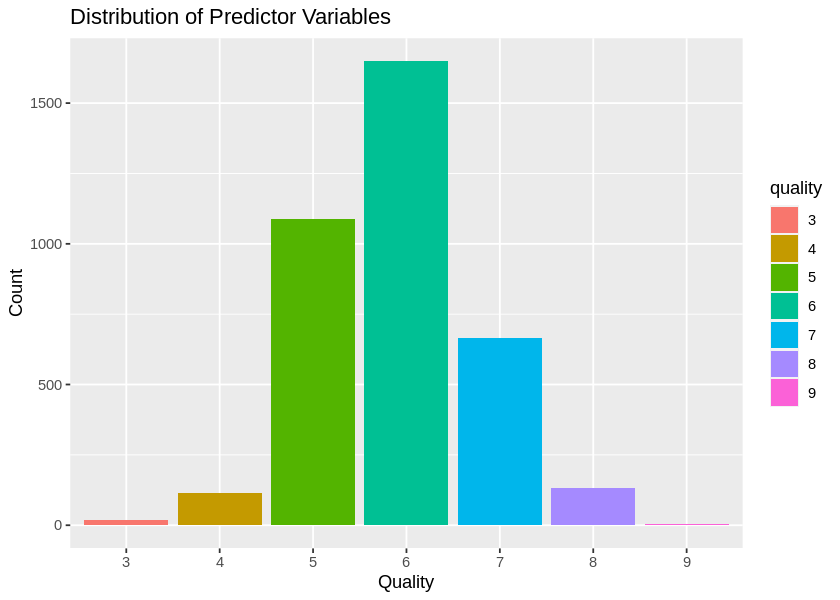

In [108]:
options(repr.plot.width=7, repr.plot.height=5)

count_plot <- summary_wine_train_data |>
            ggplot(aes(x=quality,y=total_count,fill=quality)) +
            geom_bar(stat="identity") +
            labs(x="Quality",y="Count") +
            ggtitle("Distribution of Predictor Variables")

count_plot

## Method

Our project aims to establish a classification model for white wine qualities (on a 1 -10 scale) based on the chemical ingredients in the wine. Before applying the k-nearest-neighbor classification engine to our data set, we determined to eliminate variables/columns that had minimal influence on the quality variable in our dataset. To capture these less influential variables, box plots of each variable in the data set have been constructed and displayed above, which provide visual information on the median, range, interquartile ranges, and outliers of the data under each variable. Additionally, we can infer the strength of influence each variable has on the response variable (quality) from the box plots. Variables with similar medians and interquartile ranges across every quality value are considered less influential on the response variable. As a result, we will exclude alcohol, p_h, free_sulfur_dioxide, chlorides, total_sulfure_dioxide, and fixed_acidity. The process is achievable using tidyverse functions in R. 

Subsequently, the remaining variables will be utilized as predictors to construct a scatter plot for visualization of the correlations. We will scale the variables so that the k-NN is done accurately and the results are not skewed. We will then tune the classifier using 5-fold cross-validation with different K values. Make a plot of K vs accuracy to determine the best K. Then we will use that to predict the testing data, and finally use that to collect metrics and make a confusion matrix to determine the accuracy, precision and recall of our model.

## Expected Outcomes and Significance:

We expect to develop a classification model that can predict white wine quality with reasonable accuracy. This model will reveal correlations between specific physicochemical attributes and wine quality and identify the factors that are the most influential. Our classification model can provide valuable insights for winemakers to improve their products’ quality to enhance customer satisfaction and facilitate market expansion.
However, the analysis may lead to further questions, including:
1. What is the limitation of the model? Can it be applied to other wines like red wine? 
2. Are there any other factors affecting wine quality that the model has not considered?
3. Will this model be useful in different regions with different climate conditions? Will these factors influence the quality of wine?
